In [1]:
import cv2
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from utils import visualize, visualize_multiscale, map_class, parse_model_class_file
from cam_techniques import ScoreCAM

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

imgTransform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])


pathImgs = ['/mnt/nas/share/sagar/XAI/val_categorised/590/ILSVRC2012_val_00006215.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/591/ILSVRC2012_val_00006227.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/596/ILSVRC2012_val_00004802.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/667/ILSVRC2012_val_00009855.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/689/ILSVRC2012_val_00019027.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/764/ILSVRC2012_val_00011982.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/887/ILSVRC2012_val_00001805.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/1000/ILSVRC2012_val_00004949.JPEG']

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

vgg = models.vgg16(pretrained=True).eval().to(device)
layer = vgg.features[29]

scorecamVGG = ScoreCAM(vgg, layer)

In [5]:
imagenet_class_file = 'misc/map_clsloc.txt'
model_class_file = 'misc/imagenet1000_clsidx_to_labels.txt'

model_classes = parse_model_class_file(model_class_file)
    
pathImg = pathImgs[0]

model_classid, class_name = map_class(int(pathImg.split('/')[-2]), imagenet_class_file, model_class_file)
print(model_classid, class_name)

795 ski


In [6]:
model_classes.keys()

dict_keys(['ids', 'classnames'])

In [7]:
model_classes['classnames'][model_classid]

'ski'

In [8]:
imgPIL = Image.open(pathImg)
LRimgPIL = transforms.Resize(50)(imgPIL)
img = imgTransform(imgPIL).to(device).unsqueeze(0)
LRimg = imgTransform(LRimgPIL).to(device).unsqueeze(0)

[(-0.5, 499.5, 374.5, -0.5), (-0.5, 65.5, 49.5, -0.5)]

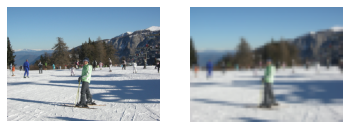

In [9]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgPIL)
ax[1].imshow(LRimgPIL)
[x.axis('off') for x in ax.ravel()]

In [10]:
scorecamMap, logits = scorecamVGG(img.to(device))
LRscorecamMap, LRlogits = scorecamVGG(LRimg.to(device))

if not os.path.exists(os.path.join('outputs', class_name)):
    os.makedirs(os.path.join('outputs',class_name))

save_path = os.path.join('outputs', class_name, 'scorecam_'+pathImg.split('/')[-1])    

pred = torch.argmax(logits)
LRpred = torch.argmax(LRlogits)
print(pred, LRpred)
print('Predictions. HR: {}, LR: {}'.format(model_classes['classnames'][pred], model_classes['classnames'][LRpred]))

tensor(795, device='cuda:0') tensor(537, device='cuda:0')
Predictions. HR: ski, LR: dogsled


True: ski. Predictions. HR: ski, LR: dogsled


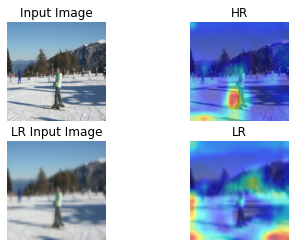

True: candle. Predictions. HR: candle, LR: milk can


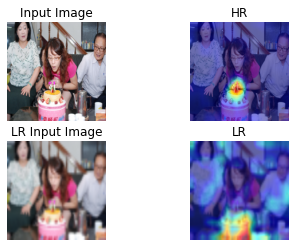

True: pier. Predictions. HR: barn, LR: worm fence


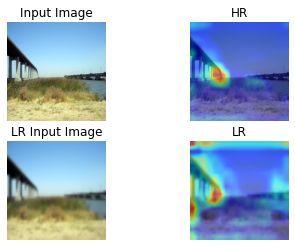

True: dishwasher. Predictions. HR: dishwasher, LR: parallel bars


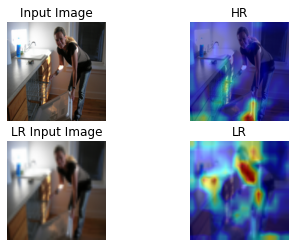

True: boathouse. Predictions. HR: boathouse, LR: container ship


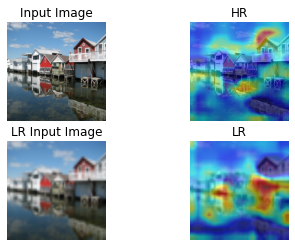

True: modem. Predictions. HR: modem, LR: can opener


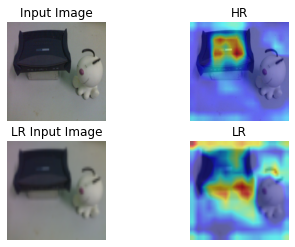

True: bullet train. Predictions. HR: streetcar, LR: tobacco shop


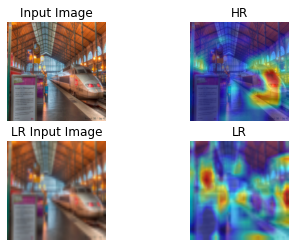

True: dumbbell. Predictions. HR: barbell, LR: dumbbell


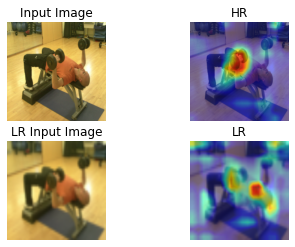

In [15]:
for pathImg in pathImgs:
    model_classid, class_name = map_class(int(pathImg.split('/')[-2]), imagenet_class_file, model_class_file)
    imgPIL = Image.open(pathImg)
    LRimgPIL = transforms.Resize(50)(imgPIL)
    img = imgTransform(imgPIL).to(device).unsqueeze(0)
    LRimg = imgTransform(LRimgPIL).to(device).unsqueeze(0)
    scorecamMap, logits = scorecamVGG(img.to(device))
    LRscorecamMap, LRlogits = scorecamVGG(LRimg.to(device))

    if not os.path.exists(os.path.join('outputs', class_name)):
        os.makedirs(os.path.join('outputs',class_name))

    save_path = os.path.join('outputs', class_name, 'scorecam_'+pathImg.split('/')[-1])    
    pred = torch.argmax(logits)
    LRpred = torch.argmax(LRlogits)
    print('True: {}. Predictions. HR: {}, LR: {}'.format(
        class_name,
        model_classes['classnames'][pred], 
        model_classes['classnames'][LRpred]
    ))
    visualize_multiscale(imgPIL, LRimgPIL, scorecamMap.cpu(), LRscorecamMap.cpu())
